<a href="https://colab.research.google.com/github/OctavioGuaschi/IA901-2023S1/blob/main/projetos/Human_physical_position_detection/notebooks/Detec%C3%A7%C3%A3o_de_posi%C3%A7%C3%A3o_f%C3%ADsica_humana_Efficientnet_B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Octavio S Guaschi, 218390

---


Breno Portela, 253502

---


Cesar Bastos, 264521

---



Notebook de implementação de detecção de posição física humana

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset"
#/content/gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Neptune Config

In [3]:
! pip install neptune-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import neptune.new as neptune
from neptune.types import File


def neptune_start(name='Default'):
    run = neptune.init_run (project= 'octavioguaschi/IA901-218390',#"breno/IA901-2023S1",#
                       name=name,
                       #custom_run_id=name,
                      # tags=[model.name,'Segmento1', 'tags', 'vocab_size_2000', 'as-list-of-strings'],
                      #api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MmNmOWUxNC1iOGYyLTQ1NjEtOWI4Mi04MTRlOTUwMTgxMzcifQ==")
                       api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTM4ZmY5My1iMzE5LTQ0MzQtOTA5MS02MzUzZTkxYTI0OGIifQ==")
    return run



/usr/local/lib/python3.10/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-4-8d277147f7f8>:1: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


# Dataset Loader


In [5]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [6]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

# Train 143 (56,5%), Val 62 (24,5%), Test 48 (19%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

seed = 2809

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
print(dataset_sizes)
print(class_names)

{'train': 2169, 'val': 724, 'test': 723}
['lying', 'sitting', 'standing']


Batch of training data


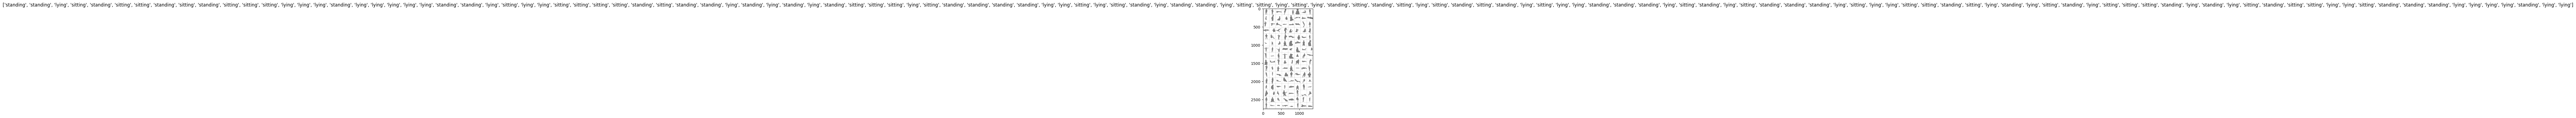

Batch of validation data


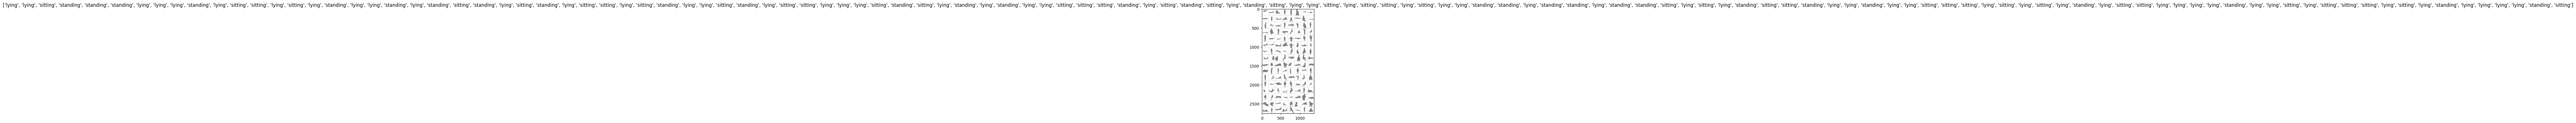

Batch of test data


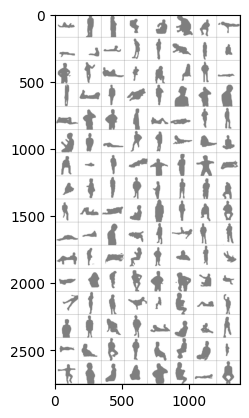

('gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/lying/422 (1).jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/standing/364.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/standing/1199.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/sitting/173.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/sitting/473.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/sitting/1175.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/sitting/394.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/lying/163.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/lying/249.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset/test/sitti

In [8]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


print('Batch of validation data')
inputs, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



print('Batch of test data')
inputs, _, paths = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

print(paths)

# Função do treinamento com Neptune

In [9]:
def train_model_Neptune(model, criterion, optimizer, scheduler,neptune, num_epochs=25):
    since = time.time()
    run = neptune
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    PARAMS = {'model': model,
              'nb_epoch': num_epochs,
              'criterion': 'Cross',
              'optimizer': optimizer.defaults,
              #'gradient_accumulation_steps': self.gradient_accumulation_steps,
              #'best_valid_loss': best_valid_loss,
              #'hparams': hparams
        }
    run['PARAMS'] = PARAMS


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                run['train/epoch_loss'].append(epoch_loss)
                run['train/epoch_acc'].append(epoch_acc)
            if phase == 'val':
                run['val/epoch_loss'].append(epoch_loss)
                run['val/epoch_acc'].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

   # run["score"] = 0.97
    run["acc"] = best_acc
    run["time_elapsed"] = time_elapsed
    # load best model weights
    model.load_state_dict(best_model_wts)
    run["model/pickled_model"].upload(File.as_pickle(model))
    return model


In [10]:

certos = 0
errados = 0
def test_model(model, num_images=48):
    was_training = model.training
    model.eval()
    images_so_far = 0
    certos = 0
    errados = 0

    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if(paths[j].split('/')[7] != class_names[preds[j]]):
                  images_so_far += 1
                  errados += 1
                  fig = plt.figure(figsize=(50, 50))
                  plt.tight_layout()
                  plt.subplot(num_images, 1, images_so_far)
                  plt.axis('off')
                  print('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                  run['test/predicted'].append('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                  imshow(inputs.cpu().data[j])
                else:
                  certos +=1
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    print('Test Acc: {:4f}'.format(certos/(certos+errados)))
                    run['test/acc'].append(certos/(certos+errados))
                    return
        model.train(mode=was_training)

# Modelo

In [11]:
#@title Efficientnet-B2

model_efficientnet_b2 = models.efficientnet_b2(pretrained = True)
num_ftrs_efficientnet_b2 = model_efficientnet_b2.classifier[1].in_features
model_efficientnet_b2.classifier[1] = nn.Linear(num_ftrs_efficientnet_b2, len(class_names))
model_efficientnet_b2 = model_efficientnet_b2.to(device)
optimizer_efficientnet_b2 = optim.SGD(model_efficientnet_b2.parameters(), lr=0.0007, momentum=0.9)
exp_lr_scheduler_efficientnet_b2 = lr_scheduler.StepLR(optimizer_efficientnet_b2, step_size=200, gamma=0.5)

summary(model_efficientnet_b2, (3,170,170))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 85, 85]             864
       BatchNorm2d-2           [-1, 32, 85, 85]              64
              SiLU-3           [-1, 32, 85, 85]               0
            Conv2d-4           [-1, 32, 85, 85]             288
       BatchNorm2d-5           [-1, 32, 85, 85]              64
              SiLU-6           [-1, 32, 85, 85]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 85, 85]               0
           Conv2d-13           [-1, 16, 85, 85]             512
      BatchNorm2d-14           [-1, 16,

In [12]:
nn_models = [model_efficientnet_b2]
models_name = ['model_efficientnet_b2']
optimizer = [optimizer_efficientnet_b2]
exp_lr_scheduler = [exp_lr_scheduler_efficientnet_b2]
num_epochs = [30]
criterion = nn.CrossEntropyLoss()
test_acc = np.zeros(1)

# Treinamento e Teste da Rede

## Efficientnet-B2

In [13]:
#@title Treinamento

run = neptune_start(models_name[0])
nn_models[0] = train_model_Neptune(nn_models[0], criterion, optimizer[0],
                                           exp_lr_scheduler[0], run, num_epochs[0])
run.stop()

<ipython-input-4-8d277147f7f8>:6: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run (project= 'octavioguaschi/IA901-218390',#"breno/IA901-2023S1",#


https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-148
Epoch 0/29
----------


<ipython-input-9-5afb26992408>:14: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torchvision.models.efficientnet.EfficientNet'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['PARAMS'] = PARAMS
<ipython-input-9-5afb26992408>:14: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['PARAMS'] = PARAMS


train Loss: 1.0690 Acc: 0.4302
val Loss: 1.0472 Acc: 0.5041

Epoch 1/29
----------
train Loss: 0.8869 Acc: 0.6860
val Loss: 0.9913 Acc: 0.6506

Epoch 2/29
----------
train Loss: 0.7247 Acc: 0.7792
val Loss: 0.7901 Acc: 0.7334

Epoch 3/29
----------
train Loss: 0.6152 Acc: 0.8119
val Loss: 0.6701 Acc: 0.7914

Epoch 4/29
----------
train Loss: 0.5318 Acc: 0.8400
val Loss: 0.5191 Acc: 0.8080

Epoch 5/29
----------
train Loss: 0.4792 Acc: 0.8506
val Loss: 0.4835 Acc: 0.8343

Epoch 6/29
----------
train Loss: 0.4366 Acc: 0.8575
val Loss: 0.4607 Acc: 0.8301

Epoch 7/29
----------
train Loss: 0.3939 Acc: 0.8774
val Loss: 0.3968 Acc: 0.8591

Epoch 8/29
----------
train Loss: 0.3643 Acc: 0.8838
val Loss: 0.4265 Acc: 0.8646

Epoch 9/29
----------
train Loss: 0.3452 Acc: 0.8834
val Loss: 0.3310 Acc: 0.8854

Epoch 10/29
----------
train Loss: 0.3156 Acc: 0.8912
val Loss: 0.3446 Acc: 0.8950

Epoch 11/29
----------
train Loss: 0.2835 Acc: 0.9073
val Loss: 0.3006 Acc: 0.9047

Epoch 12/29
----------
t

In [14]:
#@title Teste

#print(models_name[0])
#test_model(nn_models[0])
#torch.cuda.empty_cache()